In [1]:
#noah MP runoff test (runoff scheme sensitivity test, which preforms best)
#can be used for any comparison of runoff between two WRF runs
#with simple plots

In [1]:
import subprocess
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.cbook as cbook
from matplotlib.colors import Normalize
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
import os

import pandas as pd
import xarray as xr
import numpy as np
import math
from numpy import *
from pylab import *
import pygrib
import pyproj

from siphon.catalog import TDSCatalog
from siphon.http_util import session_manager
from datetime import datetime, timedelta
from xarray.backends import NetCDF4DataStore
from netCDF4 import Dataset
import metpy as metpy
import metpy.calc as mpcalc
from metpy.plots import ctables
from metpy.units import units
from metpy.plots import add_metpy_logo, add_timestamp
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter

import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
from cartopy import config
import wrf
from wrf import (to_np, interplevel, geo_bounds, getvar, ll_to_xy, ll_to_xy_proj, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
# Download and add the states and coastlines
states = NaturalEarthFeature(category="cultural", scale="50m",
                          facecolor="none", name="admin_1_states_provinces_shp")
import glob

In [2]:
#import files

#ORIG CTRL run (opt_run=8)

optrun8= sorted(glob.glob("/scratch/amanda/ivan_ensembles/ens1_ivan/hourly_d03*"))
numfiles=len(optrun8) #variable numfiles is assigned to the length of the optrun8 list of wrfout files

ivan_sfroff = []
ivan_runsf = []
ivan_raintot = []

for j in range(0,numfiles): #iterates from 0 to numfiles-1 if (0,numfiles) is specified
    ncfile= Dataset(optrun8[j]) #open each netcdf file using dataset function, filepath for all the files in the optrun8 list
    Time=wrf.extract_times(ncfile, timeidx=0, method='cat', squeeze=True, cache=None, meta=False, do_xtime=False) #extract time values and store in 'Time' variable
    timestr = str(Time)
    titletime=(timestr[0:10]+' '+timestr[11:16]) #YYYY-MM-DD HH:MM (just formatting the time info)
    filetime=(timestr[0:10]+'_'+timestr[11:13])  #YYYY-MM-DD_HH
    print('WRF valid time: ',filetime)
    
    sfroff = ncfile.variables['SFROFF'][0,:,:] #cumulative runoff in mm(all runoff up until a point)
    runsf = ncfile.variables['RUNSF'][0,:,:] #instantaneous runoff in mm/s
    lats = ncfile.variables['XLAT'][0,:,:]
    lons = ncfile.variables['XLONG'][0,:,:]
    rainc = ncfile.variables['RAINC'][0,:,:]
    rainnc = ncfile.variables['RAINNC'][0,:,:]
    
    sfroff = sfroff * 0.0393701 #convert to inches
    
    raintot = rainc + rainnc
    #p = wrf.slp (check that can calc this)
    #append the variables to the empty lists to make them 3D (need time dimension)
    
    ivan_sfroff.append(sfroff)
    ivan_runsf.append(runsf)
    ivan_raintot.append(raintot)

#checking shapes
print(np.shape(ivan_sfroff), np.shape(ivan_runsf))

#checking differences

print(np.max(ivan_sfroff), np.max(ivan_runsf))

WRF valid time:  2004-09-13_12
WRF valid time:  2004-09-13_13
WRF valid time:  2004-09-13_14
WRF valid time:  2004-09-13_15
WRF valid time:  2004-09-13_16
WRF valid time:  2004-09-13_17
WRF valid time:  2004-09-13_18
WRF valid time:  2004-09-13_19
WRF valid time:  2004-09-13_20
WRF valid time:  2004-09-13_21
WRF valid time:  2004-09-13_22
WRF valid time:  2004-09-13_23
WRF valid time:  2004-09-14_00
WRF valid time:  2004-09-14_01
WRF valid time:  2004-09-14_02
WRF valid time:  2004-09-14_03
WRF valid time:  2004-09-14_04
WRF valid time:  2004-09-14_05
WRF valid time:  2004-09-14_06
WRF valid time:  2004-09-14_07
WRF valid time:  2004-09-14_08
WRF valid time:  2004-09-14_09
WRF valid time:  2004-09-14_10
WRF valid time:  2004-09-14_11
WRF valid time:  2004-09-14_12
WRF valid time:  2004-09-14_13
WRF valid time:  2004-09-14_14
WRF valid time:  2004-09-14_15
WRF valid time:  2004-09-14_16
WRF valid time:  2004-09-14_17
WRF valid time:  2004-09-14_18
WRF valid time:  2004-09-14_19
WRF vali

In [3]:
#now, do it for the noah-mp runoff sensitivity test, which has opt_run=1

optrun1 = sorted(glob.glob("/scratch/amanda/noahmp_test_ivan/hourly_d03*"))
numfiles_test = len(optrun1)

ivan_sfroff_test = []
ivan_runsf_test = []

for j in range(0,numfiles_test):
    ncfile_test = Dataset(optrun1[j])
    Time=wrf.extract_times(ncfile_test, timeidx=0, method='cat', squeeze=True, cache=None, meta=False, do_xtime=False) #extract time values and store in 'Time' variable
    timestr = str(Time)
    titletime=(timestr[0:10]+' '+timestr[11:16]) 
    filetime=(timestr[0:10]+'_'+timestr[11:13])  
    #print('WRF valid time: ',filetime)
    
    sfroff_test = ncfile_test.variables['SFROFF'][0,:,:] #total runoff in mm
    runsf_test = ncfile_test.variables['RUNSF'][0,:,:] #instantaneous runoff in mm/s
    #slp_test = getvar(ncfile_test, "slp")
    
    sfroff_test = sfroff_test * 0.0393701 #convert to inches
    #append to make 3D
    
    ivan_sfroff_test.append(sfroff_test)
    ivan_runsf_test.append(runsf_test)
    
#checking shapes
print(np.shape(ivan_sfroff_test), np.shape(ivan_runsf_test))

#checking differences
print(np.max(ivan_sfroff_test), np.max(ivan_runsf_test))

(132, 630, 468) (132, 630, 468)
8.012746 0.43629968


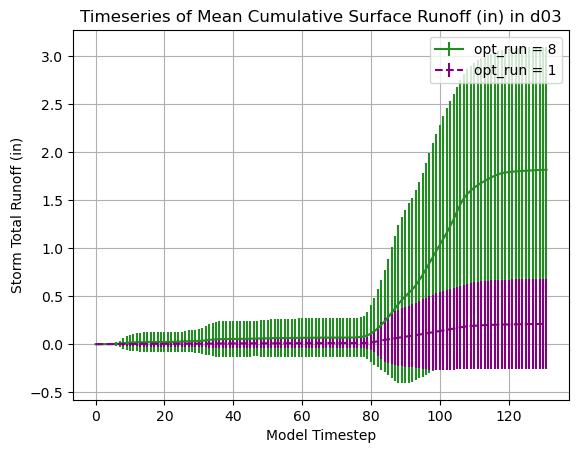

1.8153266 <function amax at 0x7efc847709a0>


In [4]:
#plot timeseries for each (on same plot for comparison)

x = [j for j in range(0,numfiles)]

y_mean= [np.mean(ivan_sfroff[j]) for j in range(0,numfiles)] #optrun8 (make sure to store these as list comprehensions and not generator expressions)
y_test_mean = [np.mean(ivan_sfroff_test[j]) for j in range(0,numfiles_test)] #optrun1

#add standard deviation bars
y_std = [np.std(ivan_sfroff[j]) for j in range(0, numfiles)]
y_test_std = [np.std(ivan_sfroff_test[j]) for j in range(0, numfiles_test)]

#use the cleaner shading method, but need to calc upper and lower bounds

plt.errorbar(x, y_mean, yerr= y_std, label = 'opt_run = 8', color= 'forestgreen')
plt.errorbar(x, y_test_mean, yerr= y_test_std, label = 'opt_run = 1', color = 'purple', linestyle = 'dashed')

plt.xlabel("Model Timestep")
plt.ylabel("Storm Total Runoff (in)")
plt.legend()
plt.grid()
plt.title('Timeseries of Mean Cumulative Surface Runoff (in) in d03')

plt.show()


print(np.max(y_mean), np.max)

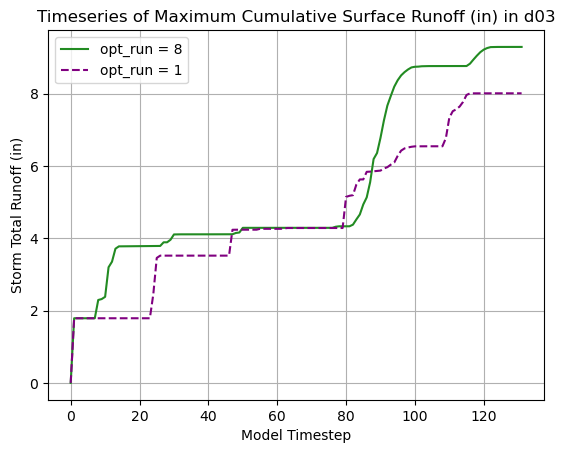

In [5]:
#plot a timeseries of the maxes now

y_max = [np.max(ivan_sfroff[j]) for j in range(0,numfiles)]
y_max_test = [np.max(ivan_sfroff_test[j]) for j in range(0,numfiles_test)]

plt.plot(x, y_max, label = 'opt_run = 8', color= 'forestgreen')
plt.plot(x, y_max_test, label = 'opt_run = 1', color = 'purple', linestyle = 'dashed')

plt.xlabel("Model Timestep")
plt.ylabel("Storm Total Runoff (in)")
plt.legend()
plt.grid()
plt.title('Timeseries of Maximum Cumulative Surface Runoff (in) in d03')

plt.show()



In [6]:
#NOW, WE WANT TO LOOK AT THE RUNOFF SENSITIVITY SPECIFICALLY IN THE AREA OF INTEREST
#do this with 'averaging box analysis'


In [7]:
#find the WRF gridpoints closest to desired lat,lon bounds of avg. box
#lats and lons to draw a box approx from cleveland, TN to winston salem, NC, with latitudes spanning the width of NC

start_lat = 34.9
end_lat=36.7
start_lon = -84.9
end_lon = -79.8

start_xy = ll_to_xy(ncfile, start_lat, start_lon, meta=False, as_int=True)
print(start_xy)

end_xy = ll_to_xy(ncfile, end_lat, end_lon, meta=False, as_int=True)
print(end_xy)

[ 25 209]
[401 372]


In [8]:
#Will use these values in the specification of the size of the array for the variables in the avg box (auto updates when change the end_lat, etc...)

i_start = start_xy[0] #i is latitudes
i_end = end_xy[0]
j_start = start_xy[1]
j_end = end_xy[1] #j is longitudes

print('length of array for trimmed i values:',i_end-i_start)
print('length of array for trimmed j values:',j_end-j_start)

length of array for trimmed i values: 376
length of array for trimmed j values: 163


In [9]:
#Now define values of our variables of interest, within the box (subsetting, essentially)

#FOR opt_run = 8

sfroff_box = np.zeros([numfiles, 376, 163]) #define empty array that we will fill later

for j in range(0,numfiles):
    sfroff_box[j] = ivan_sfroff[j][i_start:i_end,j_start:j_end]
    
    lons_box=lons[i_start:i_end,j_start:j_end] #define lons and lats for plotting in box
    lats_box=lats[i_start:i_end,j_start:j_end]
    
print(np.shape(sfroff_box),',', np.mean(sfroff_box))    
    
#set all values that =0 in the array to nan, then do nanmean to exclude any zero values from the mean\
# sfroff_box[sfroff_box ==0] = np.nan
# sfroff_box_mean = np.nanmean(sfroff_box)
# print(np.shape(sfroff_box),',', sfroff_box_mean)

(132, 376, 163) , 0.260444558485886


In [10]:
#do the same thing for opt_run = 1

sfroff_box_test = np.zeros([numfiles_test, 376, 163])

for j in range(0,numfiles_test):
    sfroff_box_test[j] = ivan_sfroff_test[j][i_start:i_end,j_start:j_end]
    
    #lons and lats are the same as above, so don't need to define again
    
print(np.shape(sfroff_box_test), ',', np.mean(sfroff_box_test))

#set all values that =0 in the array to nan

# sfroff_box_test[sfroff_box_test ==0] = np.nan
# sfroff_box_test_mean = np.nanmean(sfroff_box_test)
# print(np.shape(sfroff_box_test),',', sfroff_box_test_mean)

(132, 376, 163) , 0.045072220432449184


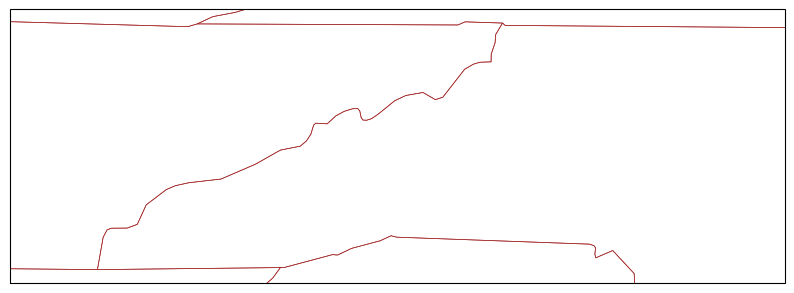

In [11]:
#testing the avg box 

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())


#ax.set_extent([-85.5, -79, 33.5, 38.5],crs.PlateCarree())
ax.set_extent([start_lon,end_lon,start_lat,end_lat],crs.PlateCarree())
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5, edgecolor='brown')
ax.coastlines('50m', linewidth=0.4)

runoff_contours = np.arange(0.5, 10, 0.1)

# for j in range(0,numfiles):
     
#     runoff_contours = ax.contourf(to_np(lons), to_np(lats), to_np(ivan_raintot[j]), levels= runoff_contours, cmap='jet', alpha=0.8, transform=ccrs.PlateCarree())
#     plt.colorbar(runoff_contours, ax=ax, orientation='horizontal', pad=0.03, shrink=0.8, aspect=50)


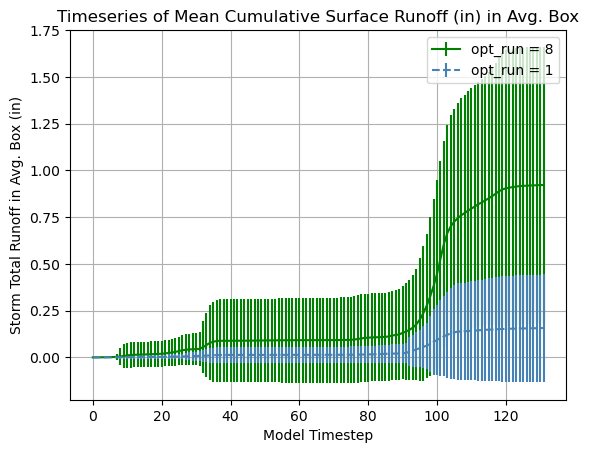

In [12]:
#Now plot timeseries of SFROFF, but only for values in the avg box

#plot timeseries for each (on same plot for comparison)

x = [j for j in range(0,numfiles)]

y_mean_box= [np.mean(sfroff_box[j]) for j in range(0,numfiles)] #optrun8 (make sure to store these as list comprehensions and not generator expressions)
y_test_mean_box = [np.mean(sfroff_box_test[j]) for j in range(0,numfiles_test)] #optrun1

#add standard deviation bars
y_std_box = [np.std(sfroff_box[j]) for j in range(0, numfiles)]
y_test_std_box = [np.std(sfroff_box_test[j]) for j in range(0, numfiles_test)]

#use the cleaner shading method, but need to calc upper and lower bounds

plt.errorbar(x, y_mean_box, yerr= y_std_box, label = 'opt_run = 8', color= 'green')
plt.errorbar(x, y_test_mean_box, yerr= y_test_std_box, label = 'opt_run = 1', color = 'steelblue', linestyle = 'dashed')

plt.xlabel("Model Timestep")
plt.ylabel("Storm Total Runoff in Avg. Box (in)")
plt.legend()
plt.grid()
plt.title('Timeseries of Mean Cumulative Surface Runoff (in) in Avg. Box')

plt.show()

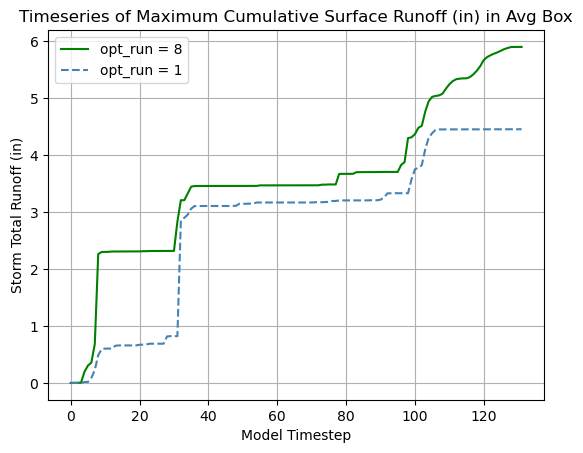

In [13]:
#plot a timeseries of the maxes now

y_max = [np.max(sfroff_box[j]) for j in range(0,numfiles)]
y_max_test = [np.max(sfroff_box_test[j]) for j in range(0,numfiles_test)]

plt.plot(x, y_max, label = 'opt_run = 8', color= 'green')
plt.plot(x, y_max_test, label = 'opt_run = 1', color = 'steelblue', linestyle = 'dashed')

plt.xlabel("Model Timestep")
plt.ylabel("Storm Total Runoff (in)")
plt.legend()
plt.grid()
plt.title('Timeseries of Maximum Cumulative Surface Runoff (in) in Avg Box')

plt.show()

In [5]:
# #mean over all times

# ivan_sfroff[ivan_sfroff ==0] = np.nan
# mean_over_time_and_grid = []
# for j in range(0,numfiles):
#     mean_over_grid = np.nanmean(ivan_sfroff[j]) #mean raunoff across the grid at all times, expluding zeroes
#     mean_over_time_and_grid.append(mean_over_grid)
#     #print(mean_over_time_and_grid)
    
# mean_over_all_times = np.mean(mean_over_time_and_grid)